# Multiple Runs Analysis

Notebook to test functions for mutiple runs simultaneously.

In [2]:
import nbimporter
import prepData as prep
import fitFunc as fits
import Statistics as stat

import matplotlib.pyplot as plt
import numpy as np 
import math

## Multiple Runs Test

### Fits

In [ ]:
x0 = 1.0353e+10+410000

In [ ]:
runsData = prep.Load()

In [ ]:
mins=np.empty(len(runsData))
maxs=np.empty(len(runsData))

for i_run,run in enumerate(runsData):
    mins[i_run]=min(run["freq"])
    maxs[i_run]=max(run["freq"])
    
    plt.plot(run["freq"],run["fft"])
    print(mins[i_run],maxs[i_run])

In [ ]:
np.min(mins),np.max(maxs)

In [ ]:
fitBkg = fits.multipleFitBKG(runsData)

In [ ]:
fitSig = fits.multipleFitSIG(runsData, fitBkg, x_0=x0)

### Confidence interval

In [43]:
def multiple_calc_qmu(toyData, x0,mu_fix):
    
    n_toy = len(toyData)
    
    # compute likelihood ratio for toy dataset
    q_mu = np.empty(n_toy)
    for i_toy,toy in enumerate(toyData):
        
        toy_bkg_params = fits.multipleFitBKG(toy)
        
        fix_toy=fits.multipleFitSIG(toy, toy_bkg_params, x_0=x0,mu_init=mu_fix,mu_vary=False)
        fitSig_toy=fits.multipleFitSIG(toy, toy_bkg_params, x_0=x0)
        
        q_mu[i_toy] = stat.multiple_lh_ratio(toy, "fft",fix_toy, "sig_bestFit",fitSig_toy,"sig_bestFit")
        
    return q_mu

In [48]:
def multipleCI(InfoDataset, fitBkg, fitSig,toy_0,x_0, mu_fix,verbose=False,draw=False):
    
    n_toy = len(toy_0)
    
    # scan for mu
    q_mu_obs_prev = 0            # save distribution and parameters
    q_mu_prev = np.empty(n_toy)  # to plot optimal result
    q0_prev = np.empty(n_toy)
    
    r_prev = 1e10
    mu_95 = 0
    
    sign_prev = 0
        
    mu_test=mu_fix
    cross_check=0
    
    all_mu=[mu_fix]
    while True:
        
        fix = fits.multipleFitSIG(InfoDataset, fitBkg, x_0=x_0,mu_init=mu_test,mu_vary=False)
        
        # compute likelihood ratio of observed data
        q_mu_obs = stat.multiple_lh_ratio(InfoDataset, "fft",
                                       fix, "sig_bestFit",
                                       fitSig, "sig_bestFit")
        
        if(verbose):
            print("Mu: ", mu_test, "   q(mu)_obs =", q_mu_obs)
        
        # generate toy datasets from fixed mu
        toy_fix = stat.multiple_toydataset(fix, n=n_toy, data_type="sig_bestFit")
        
        q_mu=multiple_calc_qmu(toy_fix,x_0,mu_test)
        q0=multiple_calc_qmu(toy_0,x_0,mu_test)
        
        # compute p-values
        p_mu = stat.p_value(q_mu_obs, q_mu)
        p_b  = stat.p_value(q_mu_obs, q0)
        
        # compute ratio
        r = p_mu/p_b
            
        if(verbose):
            print("p_mu =", p_mu, "  p_b =", p_b, "  ratio =", r, "\n")
            
        # check results to proceed with the mu scan:
        # if the ratio is close eneough to target we save the results and stop
        # else we check if we are under- or overshooting and correct the estimate
        # if we cross the target we stop and take the best result between
        # current and previous step
        
        if math.isnan(r):
            break
            
        reached_target, crossed_target, is_current_worse = False, False, False
        
        reached_target = (np.abs(r - 0.05) <= 0.01)
        if not reached_target:
            sign = np.sign(r - 0.05)
            crossed_target = (sign*sign_prev == -1)
            
            if crossed_target:
                is_current_worse = (np.abs(r - 0.05) > np.abs(r_prev - 0.05))
                cross_check+=1
        
        # update best estimate for every case except the last
        if not is_current_worse:
            q_mu_obs_prev = q_mu_obs            
            q_mu_prev = q_mu  
            q0_prev = q0
            mu_95 = mu_test
            
        if reached_target or cross_check==3:
            cross_check=0
            break
        
        #adaptive step algorithm
        step=0   
        check=r-0.05
        
        #With r=0 is better to use a huge step
        if r == 0:
            check=0.60
            
        if np.abs(check) > 0.5:
            step = sign*2
        elif ((np.abs(check) > 0.2) and (np.abs(check) < 0.5)):
            step = sign*7/5
        elif ((np.abs(check) > 0.08) and (np.abs(check) < 0.2)):
            step = sign
        else:
            step = sign*2/5
            
        # update mu if we did not exit the loop
        mu_test = mu_test + step*5
        r_prev = r
        sign_prev = sign
        
        #check if the next mu has been already tested
        if mu_test in all_mu:
            break
        else:
            all_mu.append(mu_test)
            
    # plot significance distribution
    if(draw):
        stat.plot_lhratio(q_mu_obs_prev, q0_prev, q_mu_prev, x_0, mu_95)
            
    return(mu_95)

In [49]:
def stat_test(InfoDataset,x_0,mu_fix=1.0,nToy=100,verbose=False,draw=False):
    
    #fit background once
    fitBkg = fits.multipleFitBKG(InfoDataset)
    
    # generate toy datasets from bkg and fit them
    toy_0 = stat.multiple_toydataset(fitBkg, n=nToy, data_type="bkg_bestFit")
    
    mu_CI = np.empty(len(x_0))
    for i_x0,x0 in enumerate(x_0):
        
        print("Testing x0:",x0)
        fitSig = fits.multipleFitSIG(InfoDataset, fitBkg, x_0=x0)
        
        if i_x0 == 0:
            mu_CI[i_x0] = multipleCI(InfoDataset,fitBkg,fitSig,toy_0,x0,mu_fix,verbose,draw)
        
        else:
            mu_CI[i_x0] = multipleCI(InfoDataset,fitBkg,fitSig,toy_0,x0,mu_CI[i_x0-1],verbose,draw)
        
        print("mu_CI:",mu_CI[i_x0])
        print("---------------------")
    
    return mu_CI    

In [50]:
all_freq=np.linspace(10353286068+16*651, 10353286068+31*16*651,30)
x0=all_freq
runsData = prep.Load()

x0

array([1.03532965e+10, 1.03533073e+10, 1.03533180e+10, 1.03533288e+10,
       1.03533396e+10, 1.03533504e+10, 1.03533611e+10, 1.03533719e+10,
       1.03533827e+10, 1.03533935e+10, 1.03534042e+10, 1.03534150e+10,
       1.03534258e+10, 1.03534366e+10, 1.03534473e+10, 1.03534581e+10,
       1.03534689e+10, 1.03534797e+10, 1.03534904e+10, 1.03535012e+10,
       1.03535120e+10, 1.03535228e+10, 1.03535335e+10, 1.03535443e+10,
       1.03535551e+10, 1.03535659e+10, 1.03535766e+10, 1.03535874e+10,
       1.03535982e+10, 1.03536090e+10])

Testing x0: 10353296484.0
Mu:  10    q(mu)_obs = 12.560410596284783
p_mu = 0.0   p_b = 0.03   ratio = 0.0 

Mu:  0.0    q(mu)_obs = -7.643393473699689e-09
p_mu = 0.7   p_b = 0.77   ratio = 0.9090909090909091 



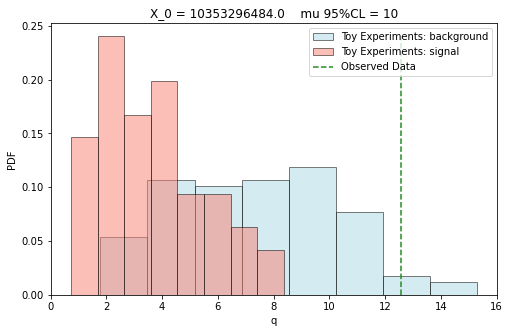

mu_CI: 10.0
---------------------
Testing x0: 10353307259.172413
Mu:  10.0    q(mu)_obs = 5.96060477694482
p_mu = 0.7   p_b = 0.95   ratio = 0.7368421052631579 

Mu:  20.0    q(mu)_obs = 34.12053330912022
p_mu = 0.13   p_b = 0.95   ratio = 0.1368421052631579 

Mu:  25.0    q(mu)_obs = 56.86064841719781
p_mu = 0.03   p_b = 0.95   ratio = 0.031578947368421054 

Mu:  23.0    q(mu)_obs = 47.07221126051081
p_mu = 0.04   p_b = 0.95   ratio = 0.04210526315789474 



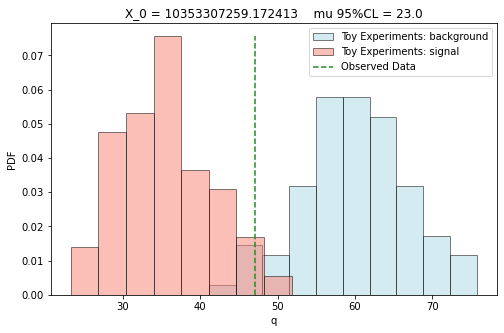

mu_CI: 23.0
---------------------
Testing x0: 10353318034.344828
Mu:  23.0    q(mu)_obs = 43.53785512608374
p_mu = 0.12   p_b = 1.0   ratio = 0.12 

Mu:  25.0    q(mu)_obs = 54.0913768432365
p_mu = 0.06   p_b = 1.0   ratio = 0.06 



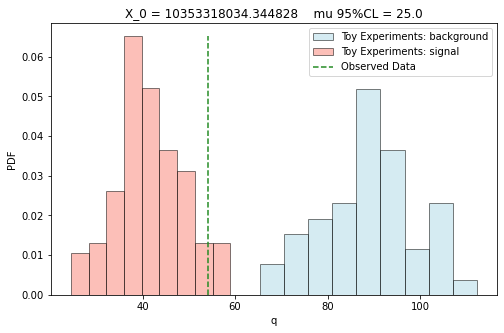

mu_CI: 25.0
---------------------
Testing x0: 10353328809.51724
Mu:  25.0    q(mu)_obs = 77.73871927184518
p_mu = 0.0   p_b = 1.0   ratio = 0.0 

Mu:  15.0    q(mu)_obs = 20.28261617111275
p_mu = 0.41   p_b = 1.0   ratio = 0.41 

Mu:  22.0    q(mu)_obs = 56.59822506551063
p_mu = 0.03   p_b = 1.0   ratio = 0.03 

Mu:  20.0    q(mu)_obs = 44.36301621520761
p_mu = 0.07   p_b = 1.0   ratio = 0.07 



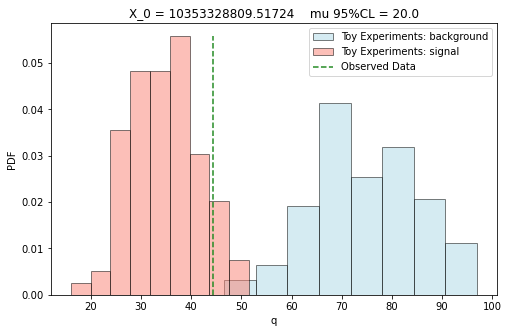

mu_CI: 20.0
---------------------
Testing x0: 10353339584.689655
Mu:  20.0    q(mu)_obs = 77.84380794374738
p_mu = 0.0   p_b = 0.87   ratio = 0.0 

Mu:  10.0    q(mu)_obs = 17.19458211669553


In [ ]:
muCL=stat_test(runsData,x0,mu_fix=10,verbose=True,draw=True)

In [ ]:
muCL
plt.plot(x0,muCL)

### test

In [ ]:
fitBkg = fits.multipleFitBKG(runsData)
toy_0 = stat.multiple_toydataset(fitBkg, n=100, data_type="bkg_bestFit")